In [2]:
import numpy as np
import os as os
import networkx as nx
import matplotlib.ticker as ticker
import pandas as pd
import glob
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score as nMI
from tqdm.auto import tqdm

# Parameters

In [3]:
folder = '/data/AG/geocluster/'
methods = ['modularity_signed', 'threshold', 'continuous_normalized', 'linearized'] 

#Girvan-Newman
p_in = np.round(np.concatenate((np.linspace(0.15,0.34,20),np.linspace(0.36,0.42,4))),2) #edge prob. inside clusters
z_out = (0.5-p_in)/3*96 #node degree between clusters

#Fan
w_in = np.round(np.concatenate((np.linspace(1.0,1.15,7),np.linspace(1.2,1.7,6))),3)#edge weight inside clusters

#LFR
mu = np.array([0.1,0.2,0.3,0.4,0.5]) #mixing

# Functions

In [6]:
#Fraction of correctly identified nodes
def fracCIN(C,D):
    m, n = int(max(C)+1), int(max(D)+1)
    Mi, k, p = np.zeros(n), np.zeros(m), np.zeros(m)
    
    for i in range(m):
        for j in range(n):
            Mi[j] = len(np.intersect1d(np.where(C==i), np.where(D==j), assume_unique=True))
    
        k[i] = np.argmax(Mi) 
        p[i] = np.max(Mi)
        
    for j in range(n):
        if np.sum(k == j) > 1:
            p[k == j] = 0

    return np.sum(p)/len(C)


def loopOverCases(path, methods):
     
    if glob.glob(path + '/benchmark_results.pkl')  != []:
        return pickle.load(open(path + '/benchmark_results.pkl','rb'))
                
    subdirs = os.listdir(path)    
    scores = {} 
    
    #create score dictionary indexed by tuples (subdir, method, time)
    for subdir in tqdm(subdirs):
        
        files = glob.glob(path + '/' + subdir + '/*.pkl')
        assert files, "No files found in " + subdir
                                 
        for method in methods: #clustering methods
            
            fs = [f for f in files if method in f]

            for f in fs: #samples
                
                gname = f.split('/')[-1].split('_')
                gname = gname[0] + '_' + gname[1] +"_.gpickle"
                G = nx.read_gpickle(path + '/' + subdir + '/' + gname)
                stability_results = pickle.load(open(f,'rb'))
                labels = np.array(stability_results[1]['community_id']) 
                times = np.array(stability_results[1]['Markov time']) 
                labels_gt = [int(G.nodes[i]['block']) for i in G.nodes]
                labels_gt = np.roll(labels_gt,-1) #this is to correct the labelling error
                
                for l, time in enumerate(times): #Markov times
                
                    nMItemp = nMI(labels_gt,labels[l],average_method='arithmetic')
                    fracCINtemp = fracCIN(np.array(labels_gt), labels[l])   
                    
                    if ((subdir, method, time,'nMI') in scores.keys() or (subdir, method, time,'fracCIN') in scores.keys()): #append to list if key exists                                           
                        scores[(subdir, method, time, 'nMI')].append(nMItemp)
                        scores[(subdir, method, time, 'fracCIN')].append(fracCINtemp)
                    else:
                        scores[(subdir, method, time, 'nMI')] = [nMItemp]
                        scores[(subdir, method, time, 'fracCIN')] = [fracCINtemp]
                
    #create pandas dataframe    
    mux = pd.MultiIndex.from_tuples(scores.keys(), names=['subdirs','method','time','metric'])
    df = pd.DataFrame(data=list(scores.values()), index=mux)
    pickle.dump(df, open(path + '/benchmark_results.pkl','wb'))
        
    return df

# Evaluate benchmarks

In [15]:
#Girvan-Newman
scores_GN = loopOverCases(folder + 'GN', methods)
mean_GN = scores_GN.groupby(level=['subdirs', 'method','metric']).max().mean(axis=1)
std_GN = scores_GN.groupby(level=['subdirs', 'method','metric']).max().std(axis=1)

In [12]:
#Fan
scores_Fan = loopOverCases(folder + 'Fan', methods)
mean_Fan = scores_Fan.groupby(level=['subdirs', 'method','metric']).max().mean(axis=1)
std_Fan = scores_Fan.groupby(level=['subdirs', 'method','metric']).max().std(axis=1)

In [13]:
#LFR
scores_LFR = loopOverCases(folder + 'LFR/lambda_0.1', methods)
mean_LFR = scores_LFR.groupby(level=['subdirs', 'method','metric']).max().mean(axis=1)
std_LFR = scores_LFR.groupby(level=['subdirs', 'method','metric']).max().std(axis=1)

# Plots

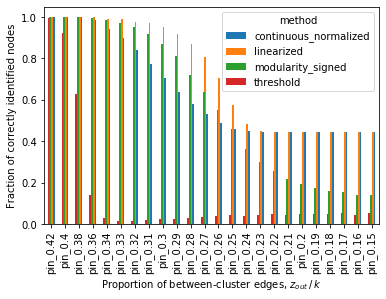

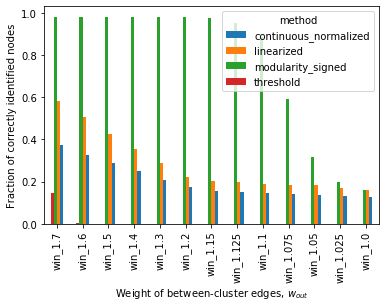

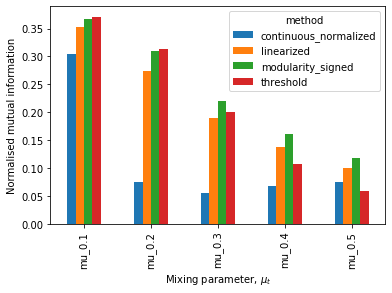

In [18]:
mean_GN.loc[(slice(None),slice(None),'nMI')].unstack(level=1).plot(kind='bar', subplots=False)
plt.xlabel(r'Proportion of between-cluster edges, $z_{out}\,/\,k$')
plt.ylabel('Fraction of correctly identified nodes')
#plt.xticks(z_out)
plt.gca().invert_xaxis()

mean_Fan.loc[(slice(None),slice(None),'fracCIN')].unstack(level=1).plot(kind='bar', subplots=False)
plt.xlabel(r'Weight of between-cluster edges, $w_{out}$')
plt.ylabel('Fraction of correctly identified nodes')
plt.gca().invert_xaxis()

mean_LFR.loc[(slice(None),slice(None),'nMI')].unstack(level=1).plot(kind='bar', subplots=False)
plt.xlabel(r'Mixing parameter, $\mu_t$')
plt.ylabel('Normalised mutual information')

plt.show()

Text(0, 0.5, 'Normalised mutual information')

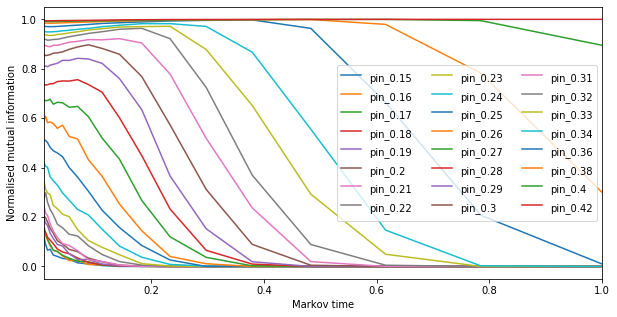

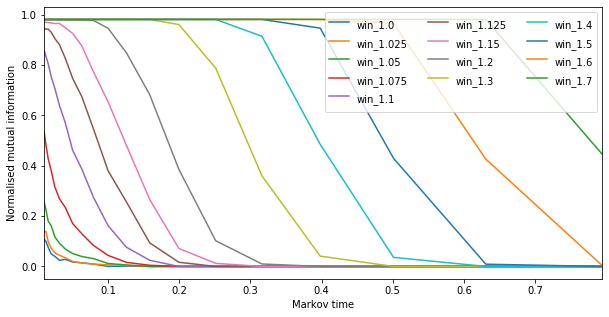

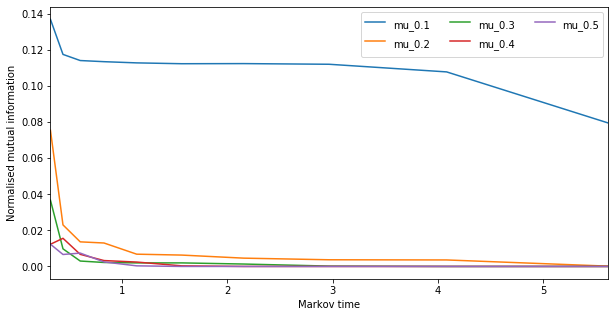

In [17]:
scores_GN.mean(axis=1).loc[(slice(None),'modularity_signed',slice(None),'fracCIN')].unstack(level=0).plot(figsize=(10,5))
plt.legend(ncol=3,handleheight=2.4, labelspacing=0.05)
plt.xlabel('Markov time')
plt.ylabel('Normalised mutual information')

scores_Fan.mean(axis=1).loc[(slice(None),'modularity_signed',slice(None),'fracCIN')].unstack(level=0).plot(figsize=(10,5))
plt.legend(ncol=3,handleheight=2.4, labelspacing=0.05)
plt.xlabel('Markov time')
plt.ylabel('Normalised mutual information')

scores_LFR.mean(axis=1).loc[(slice(None),'modularity_signed',slice(None),'fracCIN')].unstack(level=0).plot(figsize=(10,5))
plt.legend(ncol=3,handleheight=2.4, labelspacing=0.05)
plt.xlabel('Markov time')
plt.ylabel('Normalised mutual information')